## Physical model

Conservation of momentum
$$
    \nabla\cdot\sigma + \mathbf{b} = 0
$$

Isotropic linear elasticity
$$
    \sigma = 2 \mu \epsilon + \lambda \operatorname{tr}(\epsilon) \mathbf{I}
$$

Strain-displacement relation
$$
    \epsilon = \tfrac{1}{2} \left( \nabla \mathbf{u} + \nabla \mathbf{u}^\top \right)
$$

Weak formulation
$$
\begin{align*}
    \nabla\cdot\sigma + \mathbf{b} &= 0 \\
    -\nabla\cdot\sigma &= \mathbf{b} \\
    -\int_\Omega (\nabla\cdot\sigma)\cdot\mathbf{v} \,d\mathbf{x} &= \int_\Omega \mathbf{b}\cdot\mathbf{v} \,d\mathbf{x} \\
    \int_\Omega \sigma\cdot\nabla\mathbf{v} \,d\mathbf{x} &= \int_\Omega \mathbf{b}\cdot\mathbf{v} \,d\mathbf{x} + \int_{\partial \Omega} (\sigma\cdot\mathbf{n})\cdot\mathbf{v} \,d\mathbf{s} \\
    \int_\Omega \sigma(\mathbf{u})\cdot\epsilon(\mathbf{v}) \,d\mathbf{x} &= \int_\Omega \mathbf{b}\cdot\mathbf{v} \,d\mathbf{x} + \int_{\partial \Omega} \mathbf{t}\cdot\mathbf{v} \,d\mathbf{s}
\end{align*}
$$



In [1]:
%matplotlib notebook
%load_ext autoreload

In [2]:
import os
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import xarray as xr
import pygalmesh
import meshio
from mpi4py import MPI
import fenics as fe
import fenics_adjoint as fa
import torch
import torch.nn.functional as F
import torch_fenics

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import sys
sys.path.append('..')
import project

In [3]:
# configuration settings
case_name = 'Case2Pack'
fixed_phase = 0
moving_phase = 10
mask_roi = 'lung_regions'
mesh_radius = 10

In [4]:
images = project.imaging.Emory4DCT('../data/Emory-4DCT', case_name)
images

Emory4DCT('../data/Emory-4DCT', 1 cases)

In [5]:
images[0].load_niftis()

Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T00.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T10.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T20.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T30.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T40.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T50.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T60.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T70.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T80.nii.gz
Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T90.nii.gz


In [6]:
examples = images.get_examples(mask_roi, mesh_radius)
examples[0]

{'name': 'case2_T00.nii',
 'anat_file': PosixPath('../data/Emory-4DCT/Case2Pack/NIFTI/case2_T00.nii.gz'),
 'disp_file': PosixPath('../data/Emory-4DCT/Case2Pack/CorrField/case2_T10_T00.nii.gz'),
 'mask_file': PosixPath('../data/Emory-4DCT/Case2Pack/TotalSegment/case2_T00/lung_regions.nii.gz'),
 'mesh_file': PosixPath('../data/Emory-4DCT/Case2Pack/pygalmesh/case2_T00_lung_regions_10.xdmf'),
 'mesh_radius': 10}

In [7]:
%autoreload
dataset = project.data.Dataset(examples)
a_image, e_image, u_image, mask, resolution, pde, name = dataset[0]
a_image.shape, e_image.shape, u_image.shape, mask.shape, resolution

Loading ../data/Emory-4DCT/Case2Pack/NIFTI/case2_T00.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case2Pack/CorrField/case2_T10_T00.nii.gz... (256, 256, 94, 3)
Loading ../data/Emory-4DCT/Case2Pack/TotalSegment/case2_T00/lung_regions.nii.gz... (256, 256, 94)
Loading ../data/Emory-4DCT/Case2Pack/pygalmesh/case2_T00_lung_regions_10.xdmf... 23529


(torch.Size([1, 256, 256, 94]),
 torch.Size([1, 256, 256, 94]),
 torch.Size([3, 256, 256, 94]),
 torch.Size([1, 256, 256, 94]),
 (1.1577419, 1.1577419, 2.983871))

In [8]:
# initialize elasticity image
e_image = ((mask > 0) * 5e3).detach()

In [9]:
a_image = a_image.to('cuda')
e_image = e_image.to('cuda')
u_image = u_image.to('cuda')
mask = (mask > 0).to('cuda')

e_image.requires_grad = True

points = pde.points.to('cuda')
radius = pde.radius.to('cuda')

In [11]:
%autoreload
a_dofs = project.interpolation.interpolate_image(
    a_image, mask, resolution, points, radius, kernel_size=7
)
e_dofs = project.interpolation.interpolate_image(
    e_image, mask, resolution, points, radius, kernel_size=7
)
u_dofs = project.interpolation.interpolate_image(
    u_image, mask, resolution, points, radius, kernel_size=7
)
rho_dofs = (a_dofs + 1000) * 0

In [12]:
a_dofs = a_dofs.to(dtype=torch.float64, device='cpu')
e_dofs = e_dofs.to(dtype=torch.float64, device='cpu')
u_dofs = u_dofs.to(dtype=torch.float64, device='cpu')
rho_dofs = rho_dofs.to(dtype=torch.float64, device='cpu')

In [13]:
%%time
u_pred_dofs = pde.forward(
    u_dofs[None,:,:],
    e_dofs[None,:,0],
    rho_dofs[None,:,0],
)[0]

CPU times: user 9.6 s, sys: 1.08 s, total: 10.7 s
Wall time: 12 s


In [39]:
# compute u error and sensitivity
ones = torch.ones(len(a_dofs), dtype=int)
loss = project.evaluation.mean_relative_error(u_pred_dofs, u_dofs, ones)
print(loss)

loss.backward()

tensor(0.3922, dtype=torch.float64, grad_fn=<DivBackward0>)


anat


<IPython.core.display.Javascript object>


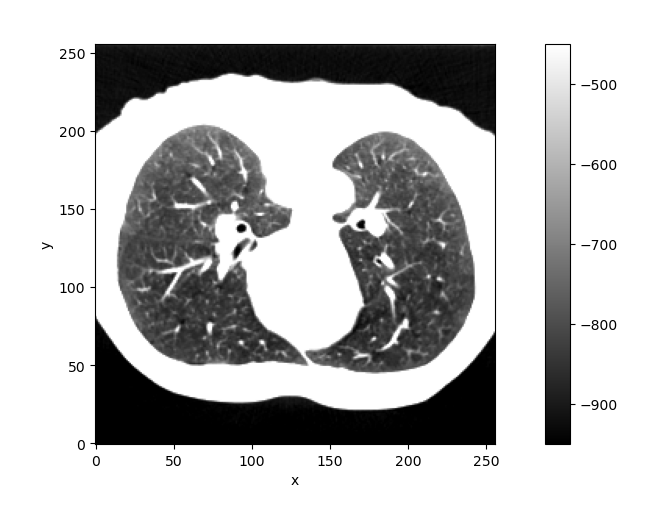

interactive(children=(SelectionSlider(description='c', options=((0, 0),), value=0), SelectionSlider(descriptio…

elast


<IPython.core.display.Javascript object>


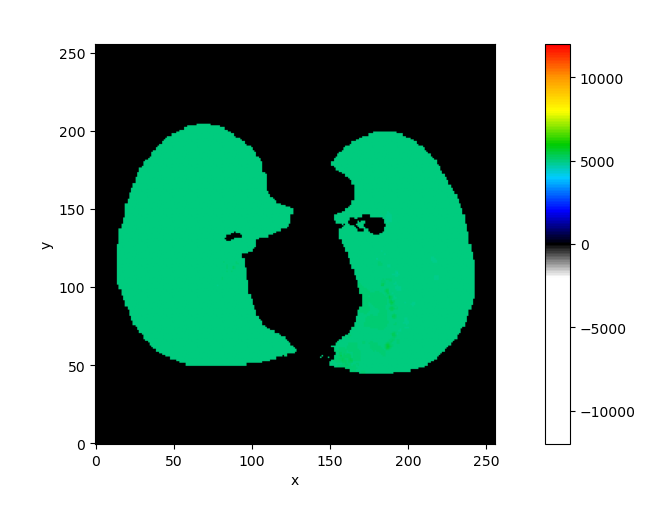

interactive(children=(SelectionSlider(description='c', options=((0, 0),), value=0), SelectionSlider(descriptio…

grad


<IPython.core.display.Javascript object>


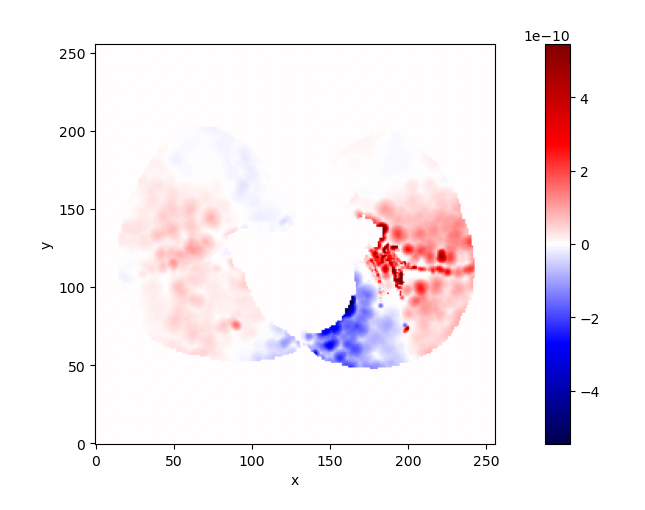

interactive(children=(SelectionSlider(description='c', options=((0, 0),), value=0), SelectionSlider(descriptio…

In [40]:
z = 45
a_viewer = project.visual.XArrayViewer(
    project.utils.as_xarray(a_image, dims=['c', 'x', 'y', 'z'], name='anat'), vmin=-950, vmax=-450
)
a_viewer.update_index(c=0, z=z)

e_viewer = project.visual.XArrayViewer(
    project.utils.as_xarray(e_image, dims=['c', 'x', 'y', 'z'], name='elast')
)
e_viewer.update_index(c=0, z=z)

g_viewer = project.visual.XArrayViewer(
    project.utils.as_xarray(e_image.grad, dims=['c', 'x', 'y', 'z'], name='grad')
)
g_viewer.update_index(c=0, z=z)

In [ ]:
# PDE-constrained optimization

lr_init = 1e2
optimizer = torch.optim.Adam([e_image], lr=lr_init)

loss_prev = np.inf
loss_best = np.inf
iter_best = 0

for i in range(100):
    optimizer.zero_grad()

    e_dofs = project.interpolation.interpolate_image(
        e_image, mask, resolution, points, radius, kernel_size=11
    ).to(dtype=torch.float64, device='cpu')

    u_pred_dofs = pde.forward(
        u_dofs[None,:,:],
        e_dofs[None,:,0],
        rho_dofs[None,:,0],
    )[0]

    loss = project.evaluation.mean_relative_error(u_pred_dofs, u_dofs, ones)
    loss_delta = (loss - loss_prev).item() / np.abs(loss_prev)
    loss_prev = loss.item()
    
    print(loss.item(), loss_delta.item())
    
    if loss < loss_best:
        loss_best = loss.item()
        iter_best = i
    elif loss_delta > 0 or (i - iter_best) > 10:
        print('decrease learning rate')
        for param_group in optimizer.param_groups:
            param_group['lr'] /= 10
    
    loss.backward()
    optimizer.step()

    e_viewer.update_array(
        project.utils.as_xarray(e_image, dims=['c', 'x', 'y', 'z'], name='elast')
    )
    g_viewer.update_array(
        project.utils.as_xarray(e_image.grad, dims=['c', 'x', 'y', 'z'], name='grad')
    )
     

/var/tmp/ipykernel_98398/3995816557.py:24: RuntimeWarning: invalid value encountered in scalar divide
  loss_delta = (loss - loss_prev).item() / np.abs(loss_prev)


0.3922458546375893 nan
0.3905687799548144 -0.004275570188815392
0.3889121673957318 -0.0042415386075514575
0.38727582959061674 -0.004207473929325647
0.38565956926048783 -0.004173408735157648
0.3840631786970952 -0.004139377551174818
0.3824864405210175 -0.004105413545309636
0.3809291278681709 -0.004071549963248994
0.3793910044196185 -0.004037820518374017
0.37787182526118657 -0.004004257193066327
0.37637133688680113 -0.003970892440441385
0.3748892778891378 -0.0039377573486928386
0.37342537936622106 -0.0039048823459539774
0.3719793651856162 -0.00387229754726109
0.3705509524549092 -0.0038400321748874775
0.36913985251315806 -0.0038081131148161307
0.36774577127052627 -0.0037765666132786426
0.36636840931677356 -0.003745418877269632
0.36500746247779536 -0.003714694838226287
0.3636626229943596 -0.0036844164070141145
0.3623335792355132 -0.0036546064258768155
0.3610200166303574 -0.003625285318372334
0.3597216178440664 -0.0035964731219331946
0.3584380630813715 -0.0035681891190963337
0.35716903091436

In [ ]:
%%time
u_pred_image = project.interpolate.dofs_to_image(u_pred_func_dofs, pde_solver.vector_space, case.shape, case.resolution)

In [ ]:
%%time
e_pred_image = project.interpolate.dofs_to_image(mu_func_dofs, pde_solver.scalar_space, case.shape, case.resolution)

In [ ]:
def estimate_limit(x, expand=0.1):
    x_min, x_max = np.min(x), np.max(x)
    x_range = (x_max - x_min)
    x_min -= expand * x_range / 2
    x_max += expand * x_range / 2
    return x_min, x_max

def plot_func(f):

    mesh = f.function_space().mesh()

    vertices = mesh.coordinates()
    n_vertices = mesh.num_vertices()
    values = f.compute_vertex_values(mesh)

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d', aspect='equal')

    X = [vertices[:,i] for i in range(3)]
    U = [values[i * n_vertices:(i + 1) * n_vertices] for i in range(3)]
    
    print(np.mean(np.linalg.norm(U, axis=1), axis=0))
       
    args = X + U
    ax.quiver(*args)
    
    ax.set_xlim(estimate_limit(vertices.flatten()))
    ax.set_ylim(estimate_limit(vertices.flatten()))
    ax.set_zlim(estimate_limit(vertices.flatten()))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    return fig, ax

plot_func(disp_fe_func)

In [ ]:
project.visual.view((reg_disp_image * 0 + sim_disp_image) * ee_lung_mask, x='x', y='z')